# Introduction to Image Processing


--- Alessandro Motta, 9th of November 2023

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

## Loading an Image

We use the [imageio](http://imageio.readthedocs.io) library to read a PNG file that contains a photo of two parrots. To display the image, we use [Matplotlib](https://matplotlib.org/).

<ipython-input-2-17842e11e29e>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_file)


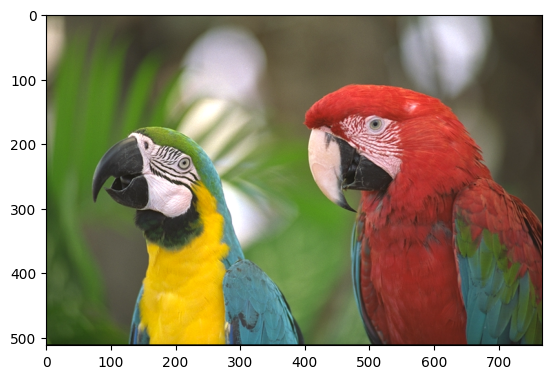

In [2]:
img_file = 'https://r0k.us/graphics/kodak/kodak/kodim23.png'
img = imageio.imread(img_file)

plt.imshow(img)
plt.show()

## Computer Representation of Images

The image is represented as a 3 dimensional array. The dimensions are

- first dimension (axis 0): rows of image pixels (from 0 at the top to 511 at bottom)
- second dimension (axis 1): columns of image pixels (from 0 at the left to 767 at the right)
- third dimension (axis 2): channels of the image (colors, see below)

Each array element is a uint8 (unsigned 8 bit integers), taking a value in the range from 0 to 255. Zero means that the color is absent in the given pixel, and 255 means that the color is at full strength in the pixel.

Questions:
- **Why use this / not use another ordering of the dimensions?**  
  NumPy uses row-major / C order. This means that the value of `img[x, y, z]` is followed in RAM by `img[x, y, z+1]`. By making the channels the last dimension, all channel values for a given pixel are right next to eachother in RAM. This improves performance of many common operations.
- **How would you represent multiple images of the same size?**  
  By an array of shape (images, height, width, channels).

In [3]:
print(f"The image has type: {type(img)}")
print(f"The n-dimensional array (ndarray) with shape: {img.shape}")
print(f"The elements of the ndarray have type: {img.dtype}")

The image has type: <class 'numpy.ndarray'>
The n-dimensional array (ndarray) with shape: (512, 768, 3)
The elements of the ndarray have type: uint8


## Plotting the Channels separately

Questions: What do the different channels represent?

- First dimension: red
- Second dimension: green
- Third dimension: blue

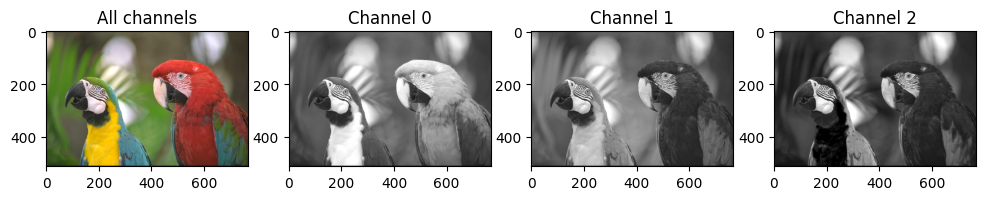

In [4]:
plt.figure(figsize=(12, 3))

ax = plt.subplot(1, 4, 1)
ax.set_title("All channels")
ax.imshow(img)

img_channels = np.split(img, img.shape[2], axis=2)
for i, img_channel in enumerate(img_channels):
  ax = plt.subplot(1, 4, 2 + i)
  ax.set_title(f"Channel {i}")
  ax.imshow(img_channel, cmap='gray')

plt.show()

## Converting Image to Grayscale

For context, see: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert

The grayscale image has shape: (512, 768)


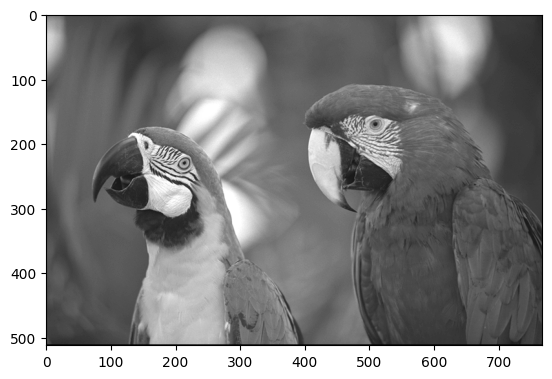

In [5]:
def to_grayscale(img):
  # Convert channels from integers 0, .., 255 to floating point numbers -1, .., 1
  img_gray = 2 * (img.astype(float) / 255) - 1
  # Separate channels
  img_gray = np.split(img_gray, img_gray.shape[2], axis=2)

  # Convert to grayscale
  img_gray = (
      img_gray[0] * 0.299 +
      img_gray[1] * 0.587 +
      img_gray[2] * 0.114
  )

  # Remove the channel dimension
  img_gray = img_gray[:, :, 0]
  return img_gray

img_gray = to_grayscale(img)
print(f"The grayscale image has shape: {img_gray.shape}")
plt.imshow(img_gray, cmap='gray', vmin=-1, vmax=+1)
plt.show()

## Modifying the Image by adding / multiplying by a Value

- **What happens when you add / subtract from the image values?**  
  Increase / decrease in brightness. Important: There is a loss of information due to clipping.
- **What happens when you multiply / decide the image values?**  
  Increase / decrease in contrast.

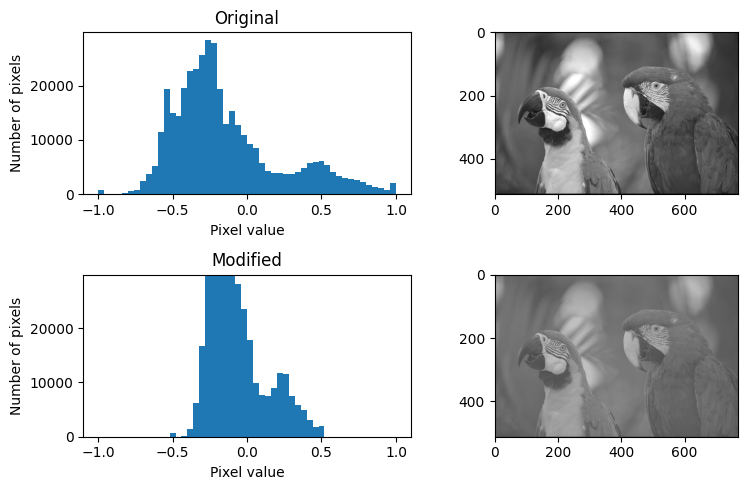

In [6]:
def plot_original_and_modified_image(img, img_modified):
  plt.figure(figsize=(8, 5))

  # Original image
  ax = plt.subplot(2, 2, 1)
  ax.set_title("Original")
  ax.set_xlabel("Pixel value")
  ax.set_ylabel("Number of pixels")
  ax.hist(img.reshape(-1), bins=np.linspace(-1, 1, 51), range=(-1, +1))
  hist_ylim = ax.get_ylim()

  ax = plt.subplot(2, 2, 2)
  ax.imshow(img, cmap='gray', vmin=-1, vmax=+1)

  # Modified image
  ax = plt.subplot(2, 2, 3)
  ax.set_title("Modified")
  ax.set_xlabel("Pixel value")
  ax.set_ylabel("Number of pixels")
  ax.hist(img_modified.reshape(-1), bins=np.linspace(-1, 1, 51))
  ax.set_ylim(*hist_ylim)

  ax = plt.subplot(2, 2, 4)
  ax.imshow(img_modified, cmap='gray', vmin=-1, vmax=+1)

  plt.tight_layout()
  plt.show()

# Modify the image
img_modified = img_gray / 2.0
# Make sure that the values stay within -1, .., +1
img_modified = np.clip(img_modified, -1, +1)

plot_original_and_modified_image(img_gray, img_modified)

## Adding an removing Noise
- **What happens if you increase the bandwidth?**  
  The noise is filtered out. However, the image is increasingly smoothed to the point of becoming blurry.


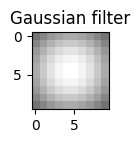

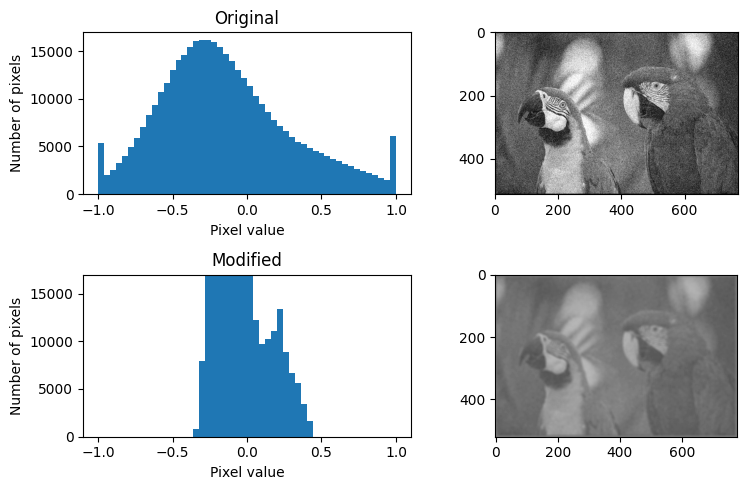

In [7]:
def make_gaussian_filter(*, bandwidth, size):
  filter = np.linspace(-(size - 1) / 2, +(size - 1) / 2, size)
  filter = np.exp(-(
      np.square(filter.reshape(size, 1) / bandwidth) +
      np.square(filter.reshape(1, size) / bandwidth)
  ) / 2) / (2 * np.pi * np.square(bandwidth))
  return filter.reshape(size, size)

# Adding noise to image
img_noisy = img_gray + 0.25 * np.random.normal(size=img_gray.shape)
img_noisy = np.clip(img_noisy, -1, +1)

# Creating Gaussian filter
gauss_filter = make_gaussian_filter(bandwidth=5, size=10)

plt.figure(figsize=(1, 1))
plt.title("Gaussian filter")
plt.imshow(gauss_filter, cmap='gray', vmin=0)
plt.show()

img_filtered = sp.signal.convolve2d(img_noisy, gauss_filter)
plot_original_and_modified_image(img_noisy, img_filtered)

## Sobel Filter
- **What does this filter do?**  
  The Sobel filter is a filter for edge detection.
- **Can you explain how it works? (Hint: look at the two filters separately)**  
  The `sobel_filter_x` filter checks how the brightness changes along the X axis. If the brightness decreases from left to right, the filter response is a large positive number. If the brightness increases, the filter response is a large negative number. Similarly, `sobel_filter_y` detects changes in brightness along the Y axis (from top to bottom).

  The filter response per pixel is computed by taking the square of `sobel_filter_x` and `sobel_filter_y` and by summing the two values. Because of the square, brightness increases and decreases result in the same (positive) value. Because of the sum of the two values, brightness changes along both dimensions are detected.
- **Could you get the same result with a single convolutional filter?**  
  No, the Sobel filter is computed as `sqrt(square(grad_x) + square(grad_y))`. The `square` and `sqrt` functions are non-linear, and a convolution can only compute linear transformations. Thus, to learn the Sobel filter with a convolutional neural network, you need multiple layers.

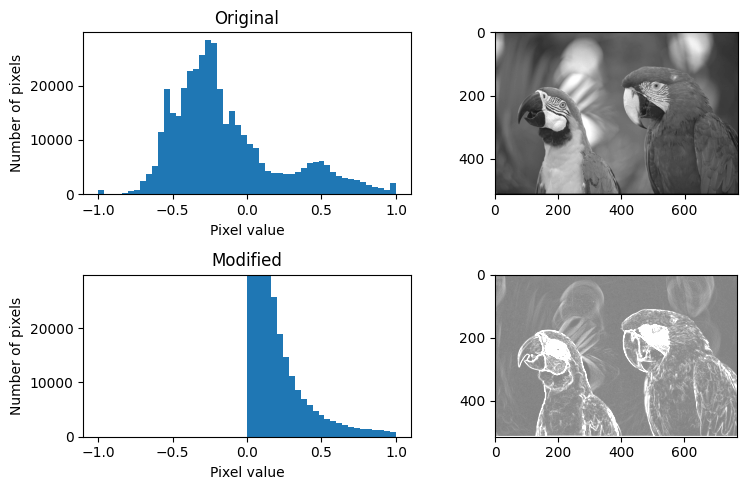

In [8]:
sobel_filter_x = np.asarray(
    [[1, 0, -1],
     [2, 0, -2],
     [1, 0, -1]],
    dtype=float
)

sobel_filter_y = np.asarray(
    [[ 1,  2,  1],
     [ 0,  0,  0],
     [-1, -2, -1]],
    dtype=float
)

img_filtered = np.sqrt(
    np.square(sp.signal.convolve2d(img_gray, sobel_filter_x)) +
    np.square(sp.signal.convolve2d(img_gray, sobel_filter_y))
)

plot_original_and_modified_image(img_gray, img_filtered)

## Lossy Image Formats
- **If you write an image as JPEG and read it back in, do you get back the original?**  
  No. JPEG uses lossy compression to reduce the image size. Thus, in the act of saving a file, information is lost irreversibly.
- **If there are differences, where are they? Can you speculate or explain why?**  
  JPEG is based on the discrete cosine transform (DCT). The high-frequency components are strongly compressed. This results in a loss of fine details at edges and stripes (around the eyes of the parrots).
- **What if you write / read the image as PNG?**  
  PNG is a lossless image format.

<ipython-input-9-abec5591ca46>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_jpeg = imageio.imread('image.jpeg')


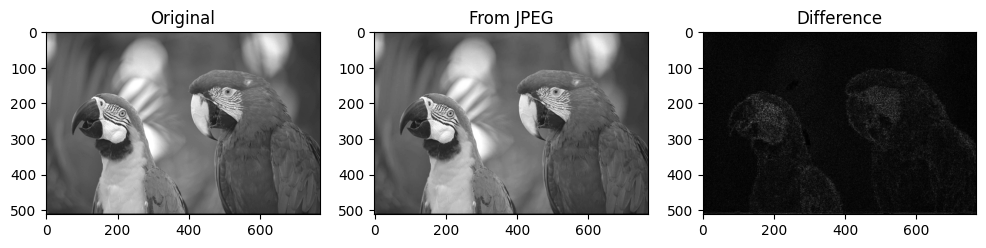

In [9]:
imageio.imwrite('image.jpeg', img)
img_jpeg = imageio.imread('image.jpeg')
img_jpeg_gray = to_grayscale(img_jpeg)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img_gray, cmap='gray', vmin=-1, vmax=+1)

plt.subplot(1, 3, 2)
plt.title('From JPEG')
plt.imshow(img_jpeg_gray, cmap='gray', vmin=-1, vmax=+1)

plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(np.abs(img_gray - img_jpeg_gray), cmap='gray', vmin=0)

plt.show()